# Using unlabelled, unfractionated datasets obtained from QExact and VOrbi instruments
* Datasets were searched against H_sapiens_Uniprot_SPROT_2017-04-12, Tryp_Pig_Bov sequence files using MSGFPlus
* Combined results with MASIC results (Q <= 0.01) to get quantitation data

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import Classification_Utils as cu
import MaxQuant_Postprocessing_Functions as mq
import numpy as np
from os import listdir
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.externals import joblib
from sklearn import preprocessing
import time

## Load (and combine?) data from all tissues

In [3]:
HIGH_QUAL_DIR = 'F:\High_Quality\\'
MIXED_QUAL_DIR = 'F:\Mixed_Quality\\'
LOW_QUAL_DIR = 'F:\Low_Quality\\'
TEST_SET_DIR = 'F:\Test_Set\\'

files_dir = 'F:\LTQOrb\\'
file_paths = listdir(files_dir) 

#files_dir2 = TEST_SET_DIR
#file_paths2 = listdir(files_dir2) 

df = cu.combine_csvs(files_dir, file_paths)

#df1 = cu.combine_csvs(files_dir, file_paths)
#df2 = cu.combine_csvs(files_dir2, file_paths2)
#df = df1.join(df2, how='outer')

In [4]:
df.dropna(axis='index', how='all', inplace=True) # drop any rows where all values are missing

original_df = df.copy()

print(df.shape)
df.head()

(17687, 49)


,Blood_Serum_Sarc_RTGlo_1_29Jan10_Draco_09-11-41,Blood_Serum_Sarc_RTGlo_10_29Jan10_Draco_09-11-43,Blood_Serum_Sarc_RTGlo_2_29Jan10_Draco_09-11-43,Blood_Serum_Sarc_RTGlo_3_29Jan10_Draco_09-11-41,Blood_Serum_Sarc_RTGlo_4_29Jan10_Draco_09-11-43,Blood_Serum_Sarc_RTGlo_5_02Feb10_Draco_09-11-41,Blood_Serum_Sarc_RTGlo_6_29Jan10_Draco_09-11-43,Blood_Serum_Sarc_RTGlo_7_29Jan10_Draco_09-11-41,Blood_Serum_Sarc_RTGlo_8_29Jan10_Draco_09-11-43,Blood_Serum_Sarc_RTGlo_9_29Jan10_Draco_09-11-41,...,Temporal_Lobe_ALZ_VP2P101_C142_9Dec08_Draco_08-10-27,Temporal_Lobe_ALZ_VP2P101_C147_28Nov08_Draco_08-10-29,Temporal_Lobe_ALZ_VP2P101_C148_28Nov08_Draco_08-10-29,Temporal_Lobe_ALZ_VP2P101_C150_10Dec08_Draco_08-10-27,Temporal_Lobe_ALZ_VP2P101_C151_28Nov08_Draco_08-10-29,Temporal_Lobe_ALZ_VP2P101_C153_13Dec08_Draco_08-10-27,Temporal_Lobe_ALZ_VP2P101_C154_28Nov08_Draco_08-10-29,Temporal_Lobe_ALZ_VP2P101_C160_7Dec08_Draco_08-10-27,Temporal_Lobe_ALZ_VP2P101_C161_27Nov08_Draco_08-10-29,Temporal_Lobe_ALZ_VP2P101_C163_9Dec08_Draco_08-10-27
Peptide,,,,,,,,,,,,,,,,,,,,,
\n-.DIQMTQSPSTLSASVGDR.V,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
\n-.KVHGSLAR.A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10326000.0,NaN
\n-.LGEHNIDVLEGNEQFINAAR.I,365750000.0,234250000.0,314170000.0,99031000.0,86449000.0,288130000.0,141240000.0,NaN,NaN,219350000.0,...,45631000.0,NaN,NaN,78341000.0,NaN,12234000.0,NaN,19340000.0,88260000.0,62144000.0
\n-.LGEHNIDVLEGNEQFINAARIITHPN.F,97629000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,22963000.0,NaN,NaN,NaN,NaN,17404000.0,NaN,24154000.0,72732000.0,NaN
\n-.LGEHNIDVLEGNEQFINAARIITHPNFN.G,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Clean data
* Log2 transform
* Impute missing values
* Mean/Median normalize

In [5]:
mq.log2_normalize(df)

df_min = df.min().min()
impute_val = df_min/2
df = df.fillna(impute_val)

# median normalize
mq.median_normalize(df)
#df.iloc[:,:] = preprocessing.RobustScaler().fit_transform(df)

C:\Users\kush494\Documents\Proteomics_Data_Processing\MaxQuant_Postprocessing_Functions.py:150: RuntimeWarning: divide by zero encountered in log2
  df.iloc[:,:] = np.log2(df.iloc[:,:])


## Map each column to a corresponding label

In [6]:
tissues = ['Blood_Plasma', 'Blood_Serum', 'CSF', 'Liver', 'Monocyte', 'Ovary', 'Pancreas', 'Substantia_Nigra', 'Temporal_Lobe']
 
tissues_to_columns = cu.map_tissues_to_columns(df, tissues)
#tissues_to_columns

In [7]:
column_names = df.columns.values.tolist()
labels = cu.get_labels(column_names, tissues_to_columns)
# Sort columns by tissue type for visualization purposes

In [8]:
from collections import Counter
counts = Counter(labels)
print(counts)

Counter({'Blood_Serum': 10, 'CSF': 10, 'Liver': 10, 'Temporal_Lobe': 10, 'Monocyte': 9})


In [9]:
df.head()

,Blood_Serum_Sarc_RTGlo_1_29Jan10_Draco_09-11-41,Blood_Serum_Sarc_RTGlo_10_29Jan10_Draco_09-11-43,Blood_Serum_Sarc_RTGlo_2_29Jan10_Draco_09-11-43,Blood_Serum_Sarc_RTGlo_3_29Jan10_Draco_09-11-41,Blood_Serum_Sarc_RTGlo_4_29Jan10_Draco_09-11-43,Blood_Serum_Sarc_RTGlo_5_02Feb10_Draco_09-11-41,Blood_Serum_Sarc_RTGlo_6_29Jan10_Draco_09-11-43,Blood_Serum_Sarc_RTGlo_7_29Jan10_Draco_09-11-41,Blood_Serum_Sarc_RTGlo_8_29Jan10_Draco_09-11-43,Blood_Serum_Sarc_RTGlo_9_29Jan10_Draco_09-11-41,...,Temporal_Lobe_ALZ_VP2P101_C142_9Dec08_Draco_08-10-27,Temporal_Lobe_ALZ_VP2P101_C147_28Nov08_Draco_08-10-29,Temporal_Lobe_ALZ_VP2P101_C148_28Nov08_Draco_08-10-29,Temporal_Lobe_ALZ_VP2P101_C150_10Dec08_Draco_08-10-27,Temporal_Lobe_ALZ_VP2P101_C151_28Nov08_Draco_08-10-29,Temporal_Lobe_ALZ_VP2P101_C153_13Dec08_Draco_08-10-27,Temporal_Lobe_ALZ_VP2P101_C154_28Nov08_Draco_08-10-29,Temporal_Lobe_ALZ_VP2P101_C160_7Dec08_Draco_08-10-27,Temporal_Lobe_ALZ_VP2P101_C161_27Nov08_Draco_08-10-29,Temporal_Lobe_ALZ_VP2P101_C163_9Dec08_Draco_08-10-27
Peptide,,,,,,,,,,,,,,,,,,,,,
\n-.DIQMTQSPSTLSASVGDR.V,2.000766,2.000766,2.000766,2.000766,2.000766,2.000766,2.000766,2.000766,2.000766,2.000766,...,2.000766,2.000766,2.000766,2.000766,2.000766,2.000766,2.000766,2.000766,2.000766,2.000766
\n-.KVHGSLAR.A,2.000766,2.000766,2.000766,2.000766,2.000766,2.000766,2.000766,2.000766,2.000766,2.000766,...,2.000766,2.000766,2.000766,2.000766,2.000766,2.000766,2.000766,2.000766,23.299778,2.000766
\n-.LGEHNIDVLEGNEQFINAAR.I,28.446283,27.803474,28.226970,26.561377,26.365346,28.102145,27.073573,2.000766,2.000766,27.708659,...,25.443511,2.000766,2.000766,26.223264,2.000766,23.544393,2.000766,24.205084,26.395256,25.889112
\n-.LGEHNIDVLEGNEQFINAARIITHPN.F,26.540806,2.000766,2.000766,2.000766,2.000766,2.000766,2.000766,2.000766,2.000766,2.000766,...,24.452808,2.000766,2.000766,2.000766,2.000766,24.052916,2.000766,24.525759,26.116087,2.000766
\n-.LGEHNIDVLEGNEQFINAARIITHPNFN.G,2.000766,2.000766,2.000766,2.000766,2.000766,2.000766,2.000766,2.000766,2.000766,2.000766,...,2.000766,2.000766,2.000766,2.000766,2.000766,2.000766,2.000766,2.000766,2.000766,2.000766


### Optional step to transform data

In [10]:
### Function to wrap whatever additional transformation is done to the train set, so that it can later be applied to the test set
def reduce_features(df):
    df = cu.keep_percentile_features(df, labels, 25)
    #df = cu.keep_k_best_features(df, labels, 500)
    return df
    

In [11]:
transform_start_time = time.time()

df = reduce_features(df)
features_to_keep = df.index.values.tolist()

print("--- %s minutes ---" % ((time.time() - transform_start_time)/60))
print(df.shape)

--- 0.0006166656812032063 minutes ---
(4422, 49)


### For testing purposes: threshold data

In [267]:
import math

df_t = df.T
num_rows = df_t.shape[1]

one_protein_df = df_t.drop(df_t.columns[list(range(num_rows-1))], axis=1)
fifteen_protein_df = df_t.drop(df_t.columns[list(range(num_rows-15))], axis=1)
sixteenthpercent_df = df_t.drop(df_t.columns[list(range(math.floor(num_rows*(1599/1600))))], axis=1)
eighthpercent_df = df_t.drop(df_t.columns[list(range(math.floor(num_rows*(799/800))))], axis=1)
quarterpercent_df = df_t.drop(df_t.columns[list(range(math.floor(num_rows*(399/400))))], axis=1)
halfpercent_df = df_t.drop(df_t.columns[list(range(math.floor(num_rows*(199/200))))], axis=1)
one_percent_df = df_t.drop(df_t.columns[list(range(math.floor(num_rows*(99/100))))], axis=1)
twentieth_df = df_t.drop(df_t.columns[list(range(math.floor(num_rows*(95/100))))], axis=1)
tenth_df = df_t.drop(df_t.columns[list(range(math.floor(num_rows*(9/10))))], axis=1)
quarter_df = df_t.drop(df_t.columns[list(range(math.floor(num_rows*(3/4))))], axis=1)
half_df = df_t.drop(df_t.columns[list(range(num_rows//2))], axis=1)
three_quarters_df = df_t.drop(df_t.columns[list(range(num_rows//4))], axis=1)
nine_tenths_df = df_t.drop(df_t.columns[list(range(num_rows//10))], axis=1)

In [268]:
thresholded_df = one_protein_df
thresholded_df.shape

(89, 1)

## Visualize data
* Normalized boxplots
* Scree plot
* PCA plot
* Pearson Matrix

In [11]:
image_dir = r'D:\Images\Human_Tissues\\'

column_to_color = mq.map_colors(tissues, tissues_to_columns, 9)

In [39]:
mq.make_seaborn_boxplot(df, image_dir, 'Median_normalized_boxplots', column_to_color)

In [12]:
#scaled_data = preprocessing.scale(df.T)
scaled_data = df.T

pca = PCA(n_components=3) # create a PCA object
pca.fit(scaled_data) # do the math
pca_data = pca.transform(scaled_data) # get PCA coordinates for dataframe

per_var, pca_labels = mq.make_scree_plot(pca, image_dir)
#mq.draw_pca_graph2(column_names, pca_data, image_dir, column_to_color, per_var, pca_labels, tissues, tissues_to_columns, 'PCA_25Percentile')
#mq.draw_pca_graph(column_names, pca_data, image_dir, column_to_color, per_var, pca_labels, 'PCA_RobustScaler_Annotated')
mq.draw_3d_pca(column_names, pca_data, image_dir, column_to_color, per_var, pca_labels, tissues, tissues_to_columns, 'PCA_25Percentile')

In [ ]:
mq.make_pearson_matrix(df, image_dir)

## Test various classifiers using cross-validation

In [12]:
NUM_SPLITS = 100
transformed_df = df.T
#transformed_df = thresholded_df

### Decision Tree

In [13]:
dt = cu.decisiontree_model_crossval(transformed_df, labels, NUM_SPLITS)

Scores: [ 0.84  1.    0.92  0.84  0.92  0.88  0.88  0.8   0.92  0.92  0.92  0.84
  0.92  0.92  0.96  0.8   0.72  0.88  0.88  0.84  0.96  0.92  0.8   0.96
  0.92  0.84  0.92  0.92  0.92  0.92  0.96  0.84  1.    0.8   0.96  0.96
  0.84  0.92  0.76  1.    0.96  0.96  0.84  0.92  0.8   0.88  0.88  0.92
  0.76  0.92  0.84  0.8   0.92  0.72  0.88  0.84  0.96  0.96  0.88  0.72
  0.8   0.92  0.96  0.88  0.96  0.96  0.92  0.92  0.92  0.84  0.92  0.92
  1.    0.8   0.84  0.84  0.92  0.8   0.92  0.88  0.8   0.92  0.84  0.84
  0.72  0.8   0.72  0.72  0.88  0.92  0.88  1.    0.88  1.    0.96  0.72
  0.96  0.92  0.72  0.88]
accuracy: 0.88 (+/- 0.15)


### KNN

In [14]:
knn = cu.knn_model_crossval(transformed_df, labels, NUM_SPLITS)

Scores: [ 0.92  0.88  0.92  0.92  0.88  0.92  0.88  0.84  0.88  0.88  0.92  0.92
  0.92  0.88  0.88  0.84  0.88  0.88  0.92  0.92  0.88  0.92  0.92  0.92
  0.92  0.92  0.88  0.56  0.92  0.88  0.92  0.88  0.92  0.88  0.88  0.92
  0.96  0.92  0.92  0.88  0.92  0.92  0.88  0.96  0.96  0.92  0.88  0.92
  0.88  0.68  0.48  0.64  0.92  0.68  0.68  1.    0.92  0.92  0.96  0.88
  0.92  0.88  0.88  0.88  0.88  0.92  0.68  0.88  0.92  0.88  0.96  0.92
  0.92  0.92  0.92  0.92  0.88  0.68  0.92  0.92  0.92  0.88  0.92  0.92
  0.84  0.88  0.52  0.92  0.88  0.92  1.    0.92  0.68  0.68  0.92  0.88
  0.92  0.92  0.68  0.92]
accuracy: 0.87 (+/- 0.19)


### Logistic Regression

In [15]:
lr = cu.logistic_regression_model_crossval(transformed_df, labels, NUM_SPLITS)

Scores: [ 1.    1.    1.    0.92  0.92  1.    1.    0.84  1.    0.92  1.    1.    1.
  0.92  1.    0.84  0.92  1.    0.92  0.84  1.    0.92  0.84  1.    1.    1.
  0.92  0.92  1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
  0.84  1.    1.    1.    1.    1.    1.    0.92  1.    1.    0.92  0.84
  0.48  0.92  1.    0.84  1.    1.    1.    1.    1.    0.92  0.92  1.    1.
  1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
  0.92  1.    0.84  0.92  0.92  1.    1.    0.92  1.    0.84  1.    0.84
  1.    1.    1.    1.    1.    0.84  1.    1.    1.    1.    1.    0.84
  1.  ]
accuracy: 0.96 (+/- 0.15)


### Naive Bayes
* Gaussian
* Multinomial

In [16]:
gnb = cu.bayes_gaussian_model_crossval(transformed_df, labels, NUM_SPLITS)

Scores: [ 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
  1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
  1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
  1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
  0.64  1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
  1.    1.    0.96  1.    0.96  1.    1.    1.    1.    1.    1.    1.    1.
  1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
  1.    1.    1.    1.    1.    1.    1.    1.    0.96  1.  ]
accuracy: 1.00 (+/- 0.07)


In [17]:
mnb = cu.bayes_multinomial_model_crossval(transformed_df, labels, NUM_SPLITS)

Scores: [ 0.92  0.88  0.92  0.92  0.88  0.92  0.88  0.84  0.88  0.96  0.92  0.92
  0.92  0.96  0.88  0.84  0.88  0.96  0.92  0.92  0.88  0.92  0.92  1.
  0.92  0.92  0.96  0.92  0.92  0.88  0.92  0.88  0.92  0.88  0.88  0.92
  1.    0.92  0.92  0.88  1.    0.92  0.88  0.96  0.96  0.92  0.88  0.92
  0.88  0.92  0.84  1.    0.92  0.96  0.88  0.96  0.96  0.92  0.96  0.96
  0.92  0.88  0.88  0.88  1.    0.92  0.88  0.88  0.92  0.88  0.96  0.92
  0.92  0.92  0.92  0.92  0.88  0.96  0.92  0.92  0.96  1.    1.    0.92
  0.84  0.88  0.92  0.96  1.    0.92  0.96  0.92  0.92  0.96  0.92  0.88
  0.92  0.92  0.84  0.96]
accuracy: 0.92 (+/- 0.08)


### SVC variations

In [18]:
svc_models = cu.SVC_models_crossval(transformed_df, labels, NUM_SPLITS)

Scores: [ 1.    1.    1.    0.92  0.92  1.    1.    0.84  1.    0.92  1.    1.    1.
  0.92  1.    0.84  0.92  1.    0.92  0.84  1.    0.92  0.84  1.    1.    1.
  0.92  0.92  1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
  0.84  1.    1.    1.    1.    1.    1.    0.92  1.    1.    0.92  0.84
  0.84  1.    1.    0.84  1.    1.    1.    1.    1.    0.92  0.92  1.    1.
  1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
  0.92  1.    0.84  0.92  0.92  1.    1.    0.92  1.    0.84  1.    0.84
  1.    1.    1.    1.    1.    0.84  1.    1.    1.    1.    1.    0.84
  1.  ]
accuracy: 0.97 (+/- 0.11)


KeyboardInterrupt: 

### Aggregations
* Random Forest
* Gradient Boosting

In [ ]:
rf = cu.randomforest_model_crossval(transformed_df, labels, NUM_SPLITS)

In [ ]:
gbc = cu.gradient_boosting_crossval(transformed_df, labels, NUM_SPLITS)

## Tune parameters of best models 
* Check accuracy score and F1 score (measure of precision and recall)

In [45]:
start_time = time.time()

### Gradient Boosting grid search

In [46]:
gbc_grid = cu.gbc_grid_search(NUM_FOLDS, 2)

gbc_grid.fit(transformed_df, labels)

print('Best Gradient Boosting parameters:\n', gbc_grid.best_params_)
print('\nBest Cross-Validation score:\n', gbc_grid.best_score_)

print("--- %s minutes ---" % ((time.time() - start_time)/60))

Best Gradient Boosting parameters:
 {'classify__max_depth': 5, 'classify__min_samples_split': 10, 'classify__n_estimators': 25, 'reduce_dim': SelectPercentile(percentile=25,
         score_func=<function f_classif at 0x000000000C3790D0>), 'reduce_dim__percentile': 25}

Best Cross-Validation score:
 0.988764044944
--- 375.56249210834505 minutes ---


### Random Forest grid search

In [47]:
rf_grid = cu.rf_grid_search(NUM_FOLDS, 2)

rf_grid.fit(transformed_df, labels)

print('Best Random Forest parameters:\n', rf_grid.best_params_)
print('\nBest Cross-Validation score:\n', rf_grid.best_score_)

print("--- %s minutes ---" % ((time.time() - start_time)/60))

Best Random Forest parameters:
 {'classify__max_features': 'log2', 'classify__min_samples_split': 10, 'classify__n_estimators': 25, 'reduce_dim': SelectPercentile(percentile=25,
         score_func=<function f_classif at 0x000000000C3790D0>), 'reduce_dim__percentile': 25}

Best Cross-Validation score:
 1.0
--- 388.9477921128273 minutes ---


### SVC grid search

In [48]:
svc_grid = cu.svc_grid_search(NUM_FOLDS, 2)

svc_grid.fit(transformed_df, labels)

print('Best SVC parameters:\n', svc_grid.best_params_)
print('\nBest Cross-Validation score:\n', svc_grid.best_score_)

print("--- %s minutes ---" % ((time.time() - start_time)/60))

Best SVC parameters:
 {'classify__C': 0.01, 'classify__kernel': 'linear', 'reduce_dim': SelectPercentile(percentile=100,
         score_func=<function f_classif at 0x000000000C3790D0>), 'reduce_dim__percentile': 100}

Best Cross-Validation score:
 0.988764044944
--- 391.3602854450544 minutes ---


## PCA of data reduced according to best grid search reduction method

In [ ]:
from sklearn.feature_selection import SelectPercentile

percentile_75_df = SelectPercentile(percentile=75).fit_transform(transformed_df, labels)
percentile_75_df.shape

In [ ]:
pca_percentile = PCA() # create a PCA object
pca_percentile.fit(percentile_75_df) # do the math
pca_data_percentile = pca_percentile.transform(percentile_75_df) # get PCA coordinates for dataframe

per_var_percentile, pca_labels_percentile = mq.make_scree_plot(pca_percentile, image_dir, 'Scree_75_Percentile')
mq.draw_pca_graph2(column_names, pca_data_percentile, image_dir, column_to_color, per_var_percentile, pca_labels_percentile, tissues, tissues_to_columns, 'PCA_75_Percentile')

## Top expressed peptides per tissue

In [ ]:
cu.print_top_n_features(df, rf, 10)
cu.print_top_n_features_coef(df, lr, 10, tissues)

## Save model, test new data
* Save array/dataframe of features (via joblib) along with final model
* Write script to classify new data-- load features and fit new data on them

### Serialize models, training data, and training features

In [51]:
finalized_model_folder = r'Trained_Models\High_Quality_Data\25Percentile_Peptides_Kept\\'
model_path = finalized_model_folder + 'highqual_crossval_rf_grid.sav'
joblib.dump(svc_grid, open(model_path, 'wb'))

In [342]:
train_data_path = finalized_model_folder + 'train_data'
joblib.dump(original_df, open(train_data_path, 'wb'))

In [343]:
train_features_path = finalized_model_folder + 'train_features'
joblib.dump(features_to_keep, open(train_features_path, 'wb'))

### Load new data (test set)

In [20]:
TEST_SET_DIR = TEST_SET_DIR
#TEST_SET_DIR = LOW_QUAL_DIR

test_paths = listdir(TEST_SET_DIR) 

test_data = cu.combine_csvs(TEST_SET_DIR, test_paths)

### Generate test_labels. Columns in test set must start with [Tissue Name]
test_labels = []
for col in test_data.columns.values.tolist():
    for tissue in tissues:
        if col.startswith(tissue):
            test_labels.append(tissue)
            continue

test_data.columns.values.tolist()
test_data = cu.fit_new_data(original_df, test_data, features_to_keep)
#test_data = cu.fit_new_data(original_df, test_data)

#loaded_train_data = joblib.load(open(train_data_path, 'rb'))
#test_data = cu.fit_new_data(loaded_train_data, test_data)

C:\Users\kush494\Documents\Proteomics_Data_Processing\Classifiers\Classification_Utils.py:522: RuntimeWarning: divide by zero encountered in log2
  fitted_data.iloc[:,:] = np.log2(fitted_data.iloc[:,:])


In [9]:
test_data.head()

Peptide,-.DIQM*TQSPSTLSASVGDR.V,-.DIQM*TQSPSTLSASVGDRVTITCR.A,-.DIQMTQSPS.T,-.DIQMTQSPSTLSASVGDR.V,-.DIQMTQSPSTLSASVGDRVTITCR.A,-.EVQLVETGGGLIQPGGSLR.L,-.KVHGSLAR.A,-.LGEHNIDVLEGNEQFINAAR.I,-.LGEHNIDVLEGNEQFINAARI.I,-.LGEHNIDVLEGNEQFINAARII.T,...,Y.YTSVTPVLR.G,Y.YTTIQDLR.D,Y.YVAPEVLGPEKYDK.S,Y.YVSNEELR.G,Y.YVTIIDAPGHR.D,Y.YVYNIIGGLDEEGK.G,Y.YWGGQYTWDM*AK.H,Y.YWGGQYTWDMAK.H,Y.YYIQQDTK.G,Y.YYIQQDTKGDYQK.A
Blood_Plasma_OpPlasma_029_a_13Aug11_Jaguar_11-07-18,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,...,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208
Blood_Plasma_OpPlasma_034_a_13Aug11_Jaguar_11-07-18,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,...,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208
Blood_Plasma_OpPlasma_038_a_13Aug11_Jaguar_11-07-16,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,...,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208
Blood_Plasma_OpPlasma_039_a_13Aug11_Jaguar_11-07-16,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,...,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208
Blood_Plasma_OpPlasma_045_a_27Jul11_Jaguar_11-05-05,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,28.611752,3.022208,3.022208,...,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208,3.022208


### Load model and predict new data

In [32]:
# some time later...
# load the model and training data from disk
model_path = finalized_model_folder + 'highqual_crossval_svc_grid.sav'
loaded_model = joblib.load(open(model_path, 'rb'))

In [33]:
pred = loaded_model.predict(test_data)
result = loaded_model.score(test_data, test_labels)

print(result)

0.481012658228


### Use models from notebook to predict new data

In [21]:
lr_pred = lr.predict(test_data)
lr_result = lr.score(test_data, test_labels)

mnb_pred = mnb.predict(test_data)
mnb_result = mnb.score(test_data, test_labels)

rf_pred = rf.predict(test_data)
rf_result = rf.score(test_data, test_labels)

svc_pred = svc_models[0].predict(test_data)
svc_result = svc_models[0].score(test_data, test_labels)

In [22]:
print(lr_result)
print(mnb_result)
print(rf_result)
print(svc_result)

0.53164556962
0.569620253165
0.544303797468
0.53164556962


In [23]:
gbc_pred = gbc.predict(test_data)
gbc_result = gbc.score(test_data, test_labels)

gnb_pred = gnb.predict(test_data)
gnb_result = gnb.score(test_data, test_labels)

knn_pred = knn.predict(test_data)
knn_result = knn.score(test_data, test_labels)

In [24]:
print(gbc_result)
print(gnb_result)
print(knn_result)

0.481012658228
0.493670886076
0.379746835443


In [55]:
gbc_grid_pred = gbc_grid.predict(test_data)
gbc_grid_result = gbc_grid.score(test_data, test_labels)

rf_grid_pred = rf_grid.predict(test_data)
rf_grid_result = rf_grid.score(test_data, test_labels)

svc_grid_pred = svc_grid.predict(test_data)
svc_grid_result = svc_grid.score(test_data, test_labels)

In [56]:
print(gbc_grid_result)
print(rf_grid_result)
print(svc_grid_result)

0.481012658228
0.430379746835
0.455696202532


##  Confusion matrices of best models' predictions on new data

Confusion matrix, without normalization
[[10  0  0  0  0  0]
 [10  0  0  0  0  0]
 [ 5  0  3  0  0  1]
 [ 0  0  0  5  5  0]
 [ 0  0  0  0  0  0]
 [ 0  0  0  0  0  0]]
Normalized confusion matrix
[[ 1.    0.    0.    0.    0.    0.  ]
 [ 1.    0.    0.    0.    0.    0.  ]
 [ 0.56  0.    0.33  0.    0.    0.11]
 [ 0.    0.    0.    0.5   0.5   0.  ]
 [  nan   nan   nan   nan   nan   nan]
 [  nan   nan   nan   nan   nan   nan]]


C:\Users\kush494\Documents\Proteomics_Data_Processing\Classifiers\Classification_Utils.py:584: RuntimeWarning: invalid value encountered in true_divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


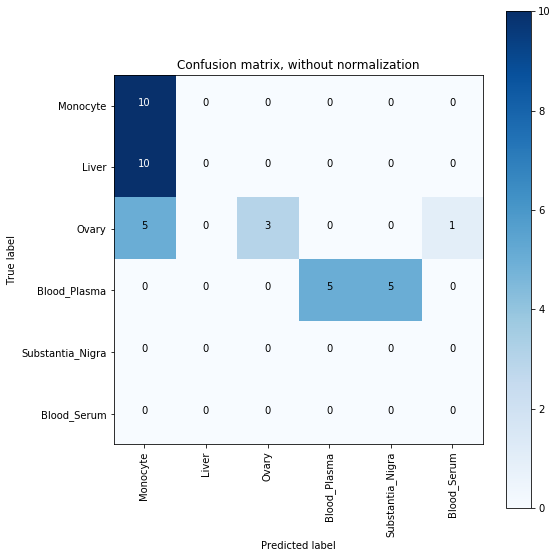

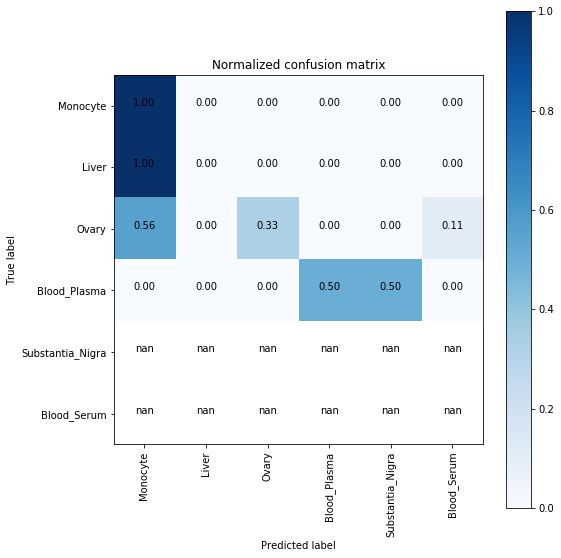

In [27]:
#cu.show_confusion_matrices(test_labels, pred, tissues)

cm_labels = list(set(gnb_pred.tolist() + test_labels))

cu.show_confusion_matrices(test_labels, gnb_pred, cm_labels)